In [1]:
#Imports
import numpy as np
from PIL import Image
import mahotas as mt
import matplotlib.pylab as plt
import sys, os
from scipy.misc import imread
import json
from collections import defaultdict
from skimage.restoration import inpaint
%matplotlib inline

In [2]:
#Loading labels
ddsm_path = './data'
labels_fl = 'mass_to_label.json'
labels_path = os.path.join(ddsm_path,labels_fl)

with open(labels_path) as data_file:    
    labels_data = json.load(data_file)

#labels_data is a filename -> label dict
mal_ind = 200
imlist = labels_data.keys()
mal_im  = imlist[mal_ind]
print mal_im
labels_data[imlist[mal_ind]]

P_00891_RIGHT_MLO.tif


1

In [3]:
#Loading training set, defining path variables
ddsm_path = './data'
train_path = os.path.join(ddsm_path,'train_set')
test_path = os.path.join(ddsm_path,'val_set')
val_path = os.path.join(ddsm_path,'test_set')
seg_path =  os.path.join(ddsm_path,'masks_cropped')

def load_batch(im_pth,seg_pth):
    im_dict = {}
    imlst = os.listdir(im_pth)
    for fl in imlst:
        tmp =  Image.open(os.path.join(im_pth,fl)) 
        try:
            seg =  Image.open(os.path.join(seg_pth,fl)) 
        except:
            continue
    #print labels_data[fl]
        tmp = np.array(tmp.resize((224,224)),dtype=np.uint8)
        seg = np.array(seg.resize((224,224)),dtype=np.uint8)
        imseg = np.stack((tmp,seg))
        im_dict[fl] = imseg
    print("Size of seg-tf set is %d out of %d possible" % (len(im_dict),len(imlst)))
    return im_dict
            

In [4]:
#Plotting image from train set
trn_data = load_batch(train_path,seg_path)
val_data = load_batch(val_path,seg_path)
test_data = load_batch(test_path,seg_path)

Size of seg-tf set is 926 out of 1034 possible
Size of seg-tf set is 258 out of 292 possible
Size of seg-tf set is 165 out of 177 possible


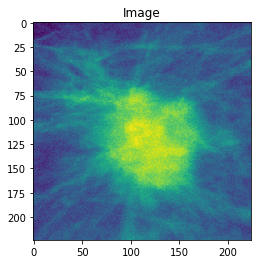

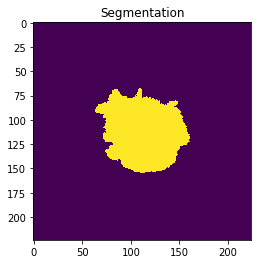

In [5]:
plt.figure()
plt.imshow(trn_data[imlist[mal_ind]][0,:,:],cmap='viridis')
plt.title('Image')
plt.figure()
plt.imshow(trn_data[imlist[mal_ind]][1,:,:],cmap='viridis')
plt.title('Segmentation')

In [5]:
IMAGE_DIM = 224

import copy 
import poisson_blending
from skimage.transform import rotate, resize
from skimage import img_as_ubyte, img_as_float
from scipy import ndimage

import numpy as np

def compute_bb(args, num_pixels, upper_bound=224): 
    h0, h1 = min(args[0]), max(args[0])
    w0, w1 = min(args[1]), max(args[1])
    h, w = h1-h0, w1-w0 
    
    h_lo = max(2,h0-num_pixels)
    h_hi = min(upper_bound-2,h1+num_pixels) 
    w_lo = max(2,w0-num_pixels)
    w_hi = min(upper_bound-2,w1+num_pixels) 
    h = h_hi - h_lo
    w = w_hi - w_lo

    center = (h_lo + h / 2, w_lo + w / 2)
    
    return [h_lo, h_hi, w_lo, w_hi], \
        [h0, h1, w0, w1], center

def TF_move_and_transform_structure(imsg):
    temp = copy.deepcopy(imsg)
    #remove segmented pixels from image
    args = np.where(temp[1,:,:] != 0)
    mass_seg = temp[0,args[0],args[1]] ##save mass pixels!
    temp[0,args[0],args[1]] =  0
    
    #translate/rotate/dilate segmentation
    ##test translation for now 
    h0,h1 = min(args[0]), max(args[0])
    w0,w1 = min(args[1]), max(args[1]) 
    h,w = h1-h0, w1-w0
    y_translate = np.random.randint(-h0,IMAGE_DIM-h1)
    x_translate = np.random.randint(-w0,IMAGE_DIM-w1)
    new_seg_args = [args[0]+y_translate, args[1]+x_translate]
    
    #create image with transformed tumor the only nonzero pixels
    mask = np.zeros((IMAGE_DIM, IMAGE_DIM))
    new_seg_tuples = zip(new_seg_args[0], new_seg_args[1])
    orig_seg_tuples = zip(args[0], args[1])
    args0, args1 = zip(*(set(orig_seg_tuples) - set(new_seg_tuples)))
    mask[args0,args1] = 1
    
    #replace pixels in original image with transformed tumor image
    temp[0,new_seg_args[0],new_seg_args[1]] = mass_seg

    #inpaint blank pixels (where tumor originally was, and not covered by new tumor
    new_im = inpaint.inpaint_biharmonic(temp[0,:,:], mask)
    
    return new_im

def TF_translate_structure_with_tissue(imsg, num_pixels=10, translation=None):
    imsg = np.uint8(img_as_ubyte(imsg))
    ##normal tissue
    import time 
    start = time.time()
    normal_file = './data/normals/A_0224_1.LEFT_CC.tif'
    tmp = Image.open(normal_file)
    tmp = np.array(tmp.resize((224,224)),dtype=np.uint8)
    end = time.time()
    print "\t time for opening normal:", end-start
    
    #translate/rotate/dilate segmentation
    start = time.time()
    args = np.where(imsg[:,:,1] != 0)
    bb, seg_bb, _ = compute_bb(args, num_pixels)
    h_lo, h_hi, w_lo, w_hi = bb
    h0, h1, w0, w1 = seg_bb
    end = time.time()
    print "\t time for computing bb:", end-start
    
    print "h_hi:", h_hi
    print "w_hi:", w_hi
    print "h_lo:", h_lo
    print "w_lo:", w_lo
    print "h1:", h1
    print "w1:", w1
    maxh = int(0.5*np.sqrt((h_hi-h_lo)**2 + (w_hi-w_lo)**2))
    print "maxh:", maxh
    print "lower bound:", maxh-h_lo
    print "upper bound:", IMAGE_DIM-h_hi-maxh
    if not translation: 
        y_translate = np.random.randint(-h0,IMAGE_DIM-h1)
        x_translate = np.random.randint(-w0,IMAGE_DIM-w1)
        
    else:
        y_translate, x_translate = translation
        
        maxa0, mina0 = max(args[0]), min(args[0])
        maxa1, mina1 = max(args[1]), min(args[1])
        if y_translate + maxa0 >= IMAGE_DIM: 
            y_translate = IMAGE_DIM - maxa0 - 1
        if x_translate + maxa1 >= IMAGE_DIM: 
            x_translate = IMAGE_DIM - maxa1 - 1 
        if mina0 + y_translate < 0: 
            y_translate = -mina0
        if mina1 + x_translate < 0: 
            x_translate = -mina1
        
#         if y_translate + h_hi >= IMAGE_DIM: 
#             y_translate = IMAGE_DIM - h_hi - 1
#         if x_translate + w_hi >= IMAGE_DIM: 
#             x_translate = IMAGE_DIM - w_hi - 1 
#         if h_lo + y_translate < 0: 
#             y_translate = -h_lo+1
#         if w_lo + x_translate < 0: 
#             x_translate = -w_lo+1
        
    print 'y translate:', y_translate
    print 'x translate:', x_translate
        
    new_seg_args = [args[0]+y_translate, args[1]+x_translate]
    mass_seg = imsg[h_lo:h_hi, w_lo:w_hi, 0]
    new_mask = np.zeros((IMAGE_DIM, IMAGE_DIM))
    new_mask[h_lo:h_hi,w_lo:w_hi] = 255
    
    #-39,15
    start = time.time()
    new_im = poisson_blending.blend(tmp, imsg[:,:,0], new_mask, offset=(y_translate,x_translate))    
    end = time.time()
    print "\t time for blending:", end-start
    new_seg = np.zeros((IMAGE_DIM, IMAGE_DIM))
    new_seg[new_seg_args[0],new_seg_args[1]] = 255
#     plt.figure()
#     plt.imshow(new_seg, cmap='gray')
#     plt.show()
    im = np.zeros((IMAGE_DIM,IMAGE_DIM,2))
    im[:,:,0] = img_as_float(new_im.astype(np.uint8))
    im[:,:,1] = img_as_float(new_seg.astype(np.uint8))
    
    return im

def rotate_image(img, angle, pivot):
    padX = [img.shape[1] - pivot[0], pivot[0]]
    padY = [img.shape[0] - pivot[1], pivot[1]]
    imgP = np.pad(img, [padY, padX], 'constant')
    imgR = ndimage.rotate(imgP, angle, reshape=False)
    return imgR[padY[0] : -padY[1], padX[0] : -padX[1]]

def TF_rotate_structure_with_tissue(imsg, num_pixels=10, p=None):
    imsg = np.uint8(img_as_ubyte(imsg))
    ##normal tissue
    normal_file = './data/normals/A_0224_1.LEFT_CC.tif'
    tmp = Image.open(normal_file)
    tmp = np.array(tmp.resize((224,224)),dtype=np.uint8)
    
    #translate/rotate/dilate segmentation
    args = np.where(imsg[:,:,1] != 0)
    bb, _, center = compute_bb(args, num_pixels)
    h_lo, h_hi, w_lo, w_hi = bb
    
    if not p: 
        p = np.random.randint(360)
        
    mass_seg = imsg[h_lo:h_hi, w_lo:w_hi, 0]
    new_mask = np.zeros((IMAGE_DIM, IMAGE_DIM))
    new_mask[h_lo:h_hi,w_lo:w_hi] = 255
        
    #rotate 
    center_rev = (center[1], center[0])
    rot_im = rotate_image(imsg[:,:,0], p, center_rev)
    rot_mask = rotate_image(imsg[:,:,1], p, center_rev)    
#     plt.figure()
#     plt.imshow(rot_mask, cmap='gray')
#     plt.show()
    rot_args = np.where(rot_mask != 0)
    rot_bb, _, _ = compute_bb(rot_args, num_pixels)
    rh_lo, rh_hi, rw_lo, rw_hi = rot_bb
    
    new_mask = np.zeros((IMAGE_DIM, IMAGE_DIM))
    new_mask[rh_lo:rh_hi, rw_lo:rw_hi] = 255  
    ##first: normal, second: full original \
    ##that's been transformed, third: mask \
    ##of the transformed
    new_im = poisson_blending.blend(tmp, rot_im, new_mask)    
    
    im = np.zeros((IMAGE_DIM,IMAGE_DIM,2))
    
    im[:,:,0] = img_as_float(new_im.astype(np.uint8))
    im[:,:,1] = img_as_float(rot_mask.astype(np.uint8))
    
    return im

def TF_dilate_structure_with_tissue(imsg, num_pixels=10, p=None):
    ##normal tissue
    normal_file = './data/normals/A_0224_1.LEFT_CC.tif'
    tmp = Image.open(normal_file)
    tmp = np.array(tmp.resize((224,224)),dtype=np.uint8)
    
    #translate/rotate/dilate segmentation
    args = np.where(imsg[1,:,:] != 0)
    bb, center = compute_bb(args, num_pixels)
    h_lo, h_hi, w_lo, w_hi = bb
    
    max_its = min([h_lo,IMAGE_DIM-h_hi,w_lo,IMAGE_DIM-w_hi])
    if not p: 
        p = np.random.randint(max_its)
    else:
        p = min(p,max_its)
    
    h_rz = h_hi-h_lo+p
    w_rz = w_hi-w_lo+p
    dil_im = resize(imsg[0,h_lo:h_hi,w_lo:w_hi],(h_rz,w_rz))
    dil_mask = resize(imsg[1,h_lo:h_hi,w_lo:w_hi],(h_rz,w_rz))
    dil_im = np.uint8(img_as_ubyte(dil_im))
    dil_mask = np.uint8(img_as_ubyte(dil_mask))
    hround = np.round(h_rz/2)
    wround = np.round(w_rz/2)
        
    print 'center:', center
    print 'hround:', hround 
    print 'wround:', wround
    
    new_mask = np.zeros((IMAGE_DIM, IMAGE_DIM))
    new_mask[center[0]-hround:center[0]+hround,\
             center[1]-wround:center[1]+wround] = 255
    dil_copy = imsg[0,:,:]
    plt.figure()
    plt.imshow(dil_im, cmap='gray')
    plt.show()

    dil_copy[center[0]-hround:center[0]+hround,\
             center[1]-wround:center[1]+wround] = dil_im
#     dil_copy[10:10+dil_im.shape[0],10:10+dil_im.shape[1]] = dil_im
    plt.figure()
    plt.imshow(dil_copy, cmap='gray')
    plt.show()
    print type(dil_copy[0,0])
    print type(dil_im[0,0])
    mask_copy = np.zeros((IMAGE_DIM, IMAGE_DIM))
    mask_copy[center[0]-hround:center[0]+hround,\
             center[1]-wround:center[1]+wround] = dil_mask
    

    

#     dil_args = np.where(dil_mask)
#     dil_bb, _ = compute_bb(dil_args, num_pixels)
#     dh_lo, dh_hi, dw_lo, dw_hi = dil_bb
    
#     new_mask = np.zeros((IMAGE_DIM, IMAGE_DIM))
#     new_mask[dh_lo:dh_hi, dw_lo:dw_hi] = 255  
    ##first: normal, second: full original \
    ##that's been transformed, third: mask \
    ##of the transformed
    new_im = poisson_blending.blend(tmp, dil_copy, new_mask)    
    
    im = np.zeros((2,IMAGE_DIM,IMAGE_DIM))
    
    im[0] = new_im.astype(np.uint8)
    im[1] = mask_copy
    
    return im
    

In [6]:
from skimage.transform import rotate, rescale
from PIL import Image, ImageEnhance 
from skimage.filters import gaussian

def np_to_pil(x):
    """Converts from np image in skimage float format to PIL.Image"""
    x = np.squeeze(np.uint8(img_as_ubyte(x)))
    return Image.fromarray(np.uint8(img_as_ubyte(x)))


def pil_to_np(x):
    """Converts from PIL.Image to np float format image"""
    x = np.asarray(x)
    if len(x.shape) == 2: 
        x = x[:,:,np.newaxis]
    return img_as_float(np.asarray(x))

def TF_rotate(x, angle=0.0, target=None):
    print type(x)
    print x.shape
    assert len(x.shape) == 3
    h, w, nc = x.shape

    # Rotate using edge fill mode
    return rotate(x, angle, mode='edge', order=1)

# def TF_enhance_contrast(x, p=1.0, target=None):
#     assert len(x.shape) == 3
#     h, w, nc = x.shape

#     if nc == 2: 
#         temp = np.expand_dims(x[:,:,0], axis=2)
#         enhancer = ImageEnhance.Contrast(np_to_pil(temp))
#         res = pil_to_np(enhancer.enhance(p))
#         x[:,:,0] = res 
#         return x 

#     enhancer = ImageEnhance.Contrast(np_to_pil(x))
#     return pil_to_np(enhancer.enhance(p))

def TF_enhance_contrast(x, p=1.0, target=None):
    assert len(x.shape) == 3
    h, w, nc = x.shape
    
    enhancer = ImageEnhance.Contrast(np_to_pil(x))
    return pil_to_np(enhancer.enhance(p))

def TF_blur(x, sigma=0.0, target=None):
    return gaussian(x, sigma=sigma, multichannel=True)

def TF_zoom(x, scale=1.0, target=None):
    assert len(x.shape) == 3
    h, w, nc = x.shape
    assert h == w

    # Zoom
    xc   = rescale(x, scale)
    diff = h - xc.shape[0]
    d    = int(np.floor(diff / 2.0))
    if d >= 0:
        padding = ((d, d),(d, d),(0,0)) if diff % 2 == 0 else ((d,d+1), (d,d + 1),(0,0))
        return np.pad(xc, padding, mode='edge')
    else:
        return xc[-d:h-d, -d:w-d].reshape(h, w, nc)

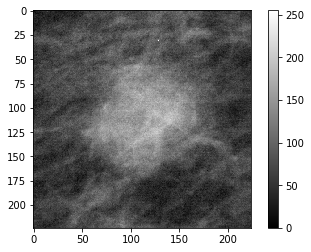

(224, 224, 2)
	 time for opening normal: 0.0123779773712
	 time for computing bb: 0.00159287452698
h_hi: 177
w_hi: 176
h_lo: 47
w_lo: 45
h1: 157
w1: 156
maxh: 92
lower bound: 45
upper bound: -45
y translate: -9
x translate: -35
	 time for blending: 1.43033385277
<type 'numpy.ndarray'>
(224, 224, 2)
<type 'numpy.ndarray'>
(224, 224, 2)
	 time for opening normal: 0.00104403495789
	 time for computing bb: 0.00156378746033
h_hi: 177
w_hi: 143
h_lo: 43
w_lo: 9
h1: 157
w1: 123
maxh: 94
lower bound: 51
upper bound: -47
y translate: -42
x translate: 90
	 time for blending: 1.26777100563
	 time for opening normal: 0.00358891487122
	 time for computing bb: 0.00178599357605
h_hi: 135
w_hi: 222
h_lo: 2
w_lo: 99
h1: 115
w1: 213
maxh: 90
lower bound: 88
upper bound: -1
y translate: 92
x translate: -109
	 time for blending: 1.03044915199
	 time for opening normal: 0.00158596038818
	 time for computing bb: 0.00168418884277
h_hi: 222
w_hi: 124
h_lo: 93
w_lo: 2
h1: 207
w1: 104
maxh: 88
lower bound: -5
u

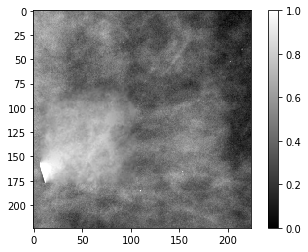

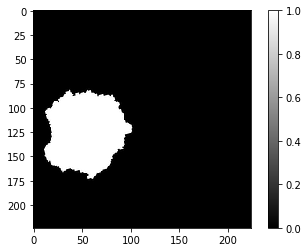

In [14]:
##Test TF number 2
temp_img = img_as_float(copy.deepcopy(trn_data[imlist[220]]))

plt.figure()
plt.imshow(np.uint8(img_as_ubyte(temp_img[0])), cmap='gray')
plt.colorbar()
plt.clim(0,255)
plt.show()

original = Image.fromarray(temp_img[0])
orig_mask = Image.fromarray(temp_img[1])
import time 
temp_img = np.transpose(temp_img, (1,2,0))
print temp_img.shape
# im = TF_translate_structure_with_tissue(temp_img, num_pixels=20, translation=(-68,-75))
im = TF_translate_structure_with_tissue(temp_img, num_pixels=20)
im = TF_rotate(im, angle=5)
im = TF_rotate(im, angle=5)
im = TF_enhance_contrast(im, p=0.9)
# im[:,:,0] = np.squeeze(im0)
#im = TF_enhance_contrast(im, p=1.15)
#im[:,:,0] = np.squeeze(im0)
im = TF_blur(im, sigma=0.1)
im = TF_blur(im, sigma=0.1)
# im = TF_zoom(im, scale=1.3)
# im = TF_zoom(im, scale=1.3)
# im = TF_zoom(im, scale=1.3)
im = TF_translate_structure_with_tissue(im, num_pixels=20)
im = TF_translate_structure_with_tissue(im, num_pixels=20)
im = TF_translate_structure_with_tissue(im, num_pixels=20)
im = TF_translate_structure_with_tissue(im, num_pixels=20)
im = TF_translate_structure_with_tissue(im, num_pixels=20)
im = TF_translate_structure_with_tissue(im, num_pixels=20, translation=(-10,-10))
im = TF_translate_structure_with_tissue(im, num_pixels=20, translation=(-10,-10))
im = TF_translate_structure_with_tissue(im, num_pixels=20)
im = TF_translate_structure_with_tissue(im, num_pixels=20)
im = TF_translate_structure_with_tissue(im, num_pixels=20)
im = TF_rotate_structure_with_tissue(im,num_pixels=1,p=15)


# start = time.time()
# im = TF_translate_structure_with_tissue(temp_img,num_pixels=20,translation=(39,15))
# end = time.time() 
# print "translate structure time:", end-start

# start = time.time()
# im2 = TF_rotate(np.expand_dims(temp_img[0],axis=2), angle=45)
# end = time.time()
# print "rotate time:", end-start

# start = time.time()
# im3 = TF_zoom(np.expand_dims(temp_img[0],axis=2), scale=1.5)
# end = time.time()
# print "zoom time:", end-start

# start = time.time()
# im4 = TF_rotate_structure_with_tissue(temp_img,num_pixels=20,p=50)
# end = time.time()
# print "rotate structure time:", end-start



new_im, new_seg = im[:,:,0], im[:,:,1]
plt.figure()
plt.imshow(new_im, cmap='gray')
plt.colorbar()
plt.clim(0,1)
plt.show()

plt.figure()
plt.imshow(new_seg, cmap='gray')
plt.colorbar()
plt.clim(0,1)
plt.show()

# new_im = new_im.astype(np.uint8)
# new = Image.fromarray(new_im)
# new.save('new_paper.tif')




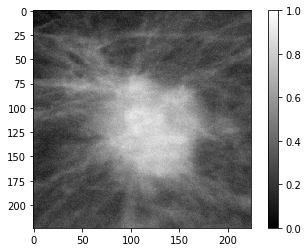

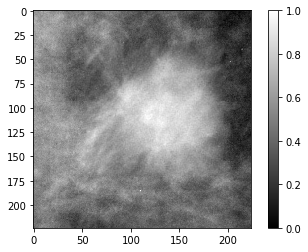

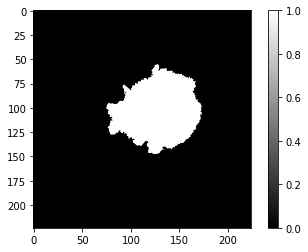

In [229]:
##Test TF Number 3
temp_img = img_as_float(copy.deepcopy(trn_data[imlist[mal_ind]]))

plt.figure()
plt.imshow(temp_img[0], cmap='gray')
plt.colorbar()
plt.clim(0,1)
plt.show()

im = TF_rotate_structure_with_tissue(temp_img,num_pixels=20,p=50)
new_im, new_seg = im[0], im[1]
plt.figure()
plt.imshow(new_im, cmap='gray')
plt.colorbar()
plt.clim(0,1)
plt.show()

plt.figure()
plt.imshow(new_seg, cmap='gray')
plt.colorbar()
plt.clim(0,1)
plt.show()

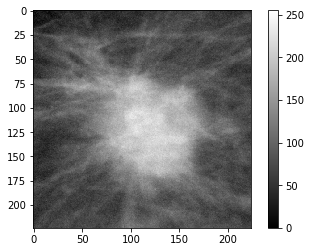

center: (111, 92)
hround: 58
wround: 63


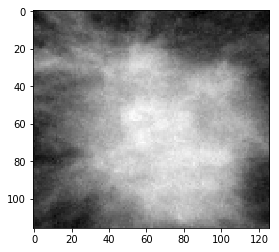

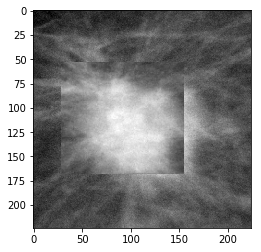

<type 'numpy.uint8'>
<type 'numpy.uint8'>


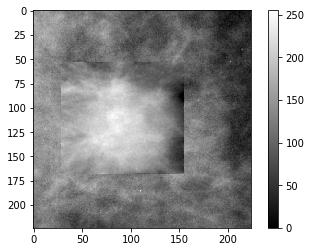

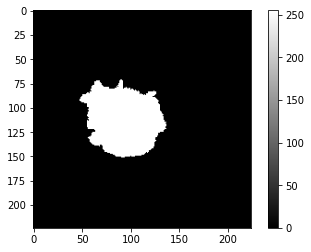

In [209]:
##Test TF Number 4
temp_img = copy.deepcopy(trn_data[imlist[mal_ind]])

plt.figure()
plt.imshow(temp_img[0], cmap='gray')
plt.colorbar()
plt.clim(0,255)
plt.show()

im = TF_dilate_structure_with_tissue(temp_img,num_pixels=20,p=-10)
new_im, new_seg = im[0], im[1]
plt.figure()
plt.imshow(new_im, cmap='gray')
plt.colorbar()
plt.clim(0,255)
plt.show()

plt.figure()
plt.imshow(new_seg, cmap='gray')
plt.colorbar()
plt.clim(0,255)
plt.show()

In [7]:
from tanda.transformer import SegmentTransformer 
from dataset import load_ddsm_data

from functools import partial 
from itertools import chain
import os
import sys

dims     = [100, 100, 2]

X_train, Y_train, X_valid, Y_valid, X_test, Y_test = load_ddsm_data(data_dir='./data/benign_malignant', \
    label_json='./data/mass_to_label.json', validation_set=True)

X_batch = X_train[:10]
X_plot = X_batch 

tf_sets = []
tfs_15 = [
    [partial(TF_rotate, angle=p) for p in [2.5, -2.5, 5, -5]],
    [partial(TF_zoom, scale=p) for p in [0.9, 1.1]],
    [partial(TF_enhance_contrast, p=p) for p in [1.15, 1.05]],
    [partial(TF_blur, sigma=0.1)],
    [partial(TF_translate_structure_with_tissue, translation=p, dim=100) \
        for p in [(10,10), (-10,-10), (5,10), (-10,5)]],
    [partial(TF_translate_structure_with_tissue, dim=100)], 
    [partial(TF_rotate_structure_with_tissue, p=p, dim=100) \
        for p in [2.5, -2.5, 15, -15]]
]
tf_sets.append(list(chain.from_iterable(tfs_15)))
tfs = tf_sets[0]

transformer = SegmentTransformer(tfs, dims)
seq_len = 10
X_plot_r = transformer.random_transform(X_plot, seq_len, emit_incremental=False)
print X_plot_r.shape

loading in 926 images...
loading in 177 images...
loading in 292 images...
<type 'numpy.ndarray'>
(100, 100, 2)


TypeError: TF_translate_structure_with_tissue() got an unexpected keyword argument 'dim'